## Get started

In [1]:
import sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")
import networkx as nx
from torch_geometric.utils import to_networkx, to_dense_adj
from torch_geometric.loader import DataLoader

sys.path.append("..")
from spikeometric.models import PoissonGLM
from spikeometric.datasets import ConnectivityDataset, UniformGenerator
from spikeometric.stimulus import SinStimulus

In this introductory example we will demonstrate the basic building blocks of the package. We will load a dataset of 100 connectivity matrices into the `ConnectivityDataset` and use the `PoissonGLM` to simulate 10 seconds of network activity.

## Step 1: The connectivity dataset

We start by loading a set of pre-defined connectivity matrices into a `ConnectivityDataset`.

In [2]:
# Load dataset of connectivity matrices
dataset = ConnectivityDataset("example_data/w0/example_dataset")
n_neurons = dataset[0].num_nodes
n_networks = len(dataset)

print(f"Number of neurons: {n_neurons}")
print(f"Number of networks: {n_networks}")

Number of neurons: 100
Number of networks: 100


The dataset is then put into a data loader provided to us by torch_geometric. By specifying a batch size of 10, the data loader will combine the networks into larger networks, each containing 10 of our networks as isolated subgraphs. This will allow us to simulate 10 networks at a time.

In [3]:
data_loader = DataLoader(dataset, batch_size=10, shuffle=False)

Before we proceed its useful to make a visualization of the networks. We'll look at three plots, a graph visualization of the network, a heatmap of the connectvity matrix and weight distribution histogram.

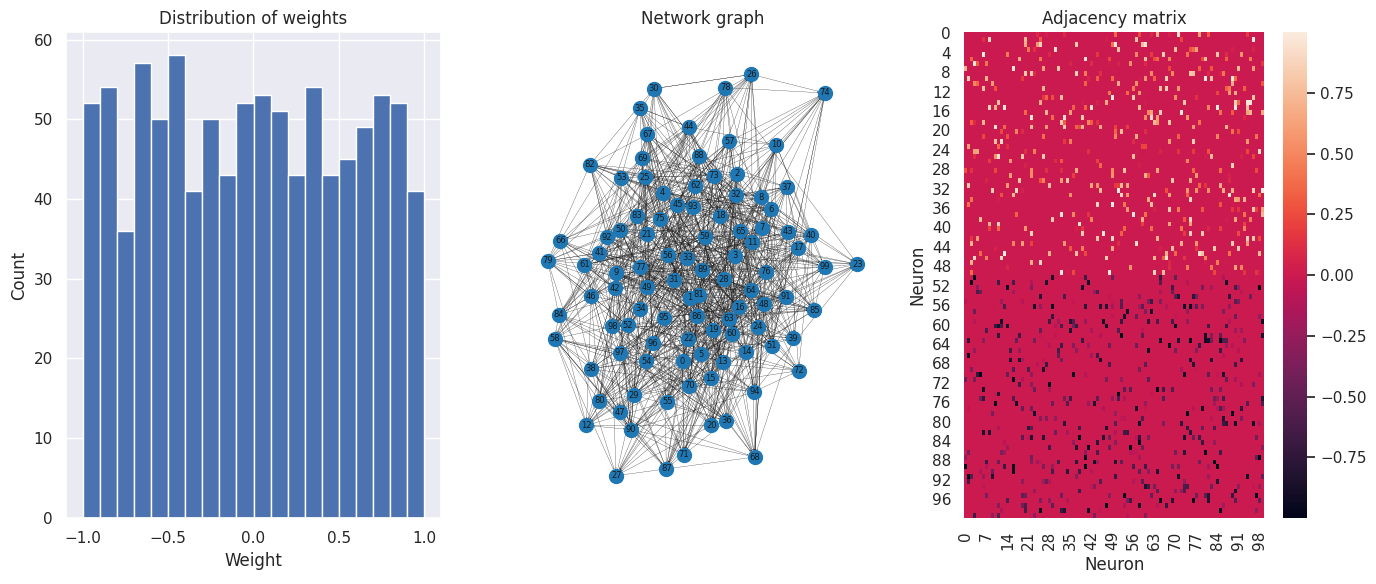

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

example_network = dataset[torch.randint(0, n_networks, (1,))]

ax[0].hist(example_network.W0, bins=20)
ax[0].set_title("Distribution of weights")
ax[0].set_xlabel("Weight")
ax[0].set_ylabel("Count")

G = to_networkx(example_network)
nx.draw(G, node_size=100, width=0.2, arrowsize=1, with_labels=True, font_size=6, ax=ax[1])
ax[1].set_title("Network graph")

square_connectivity_matrix = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(square_connectivity_matrix, ax=ax[2])
ax[2].set_title("Adjacency matrix")
ax[2].set_xlabel("Neuron")
ax[2].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

In [5]:
print(f"Mean weight: {example_network.W0.mean():.2f}")
print(f"Sparsity: {1  - example_network.W0.shape[0]/example_network.num_nodes**2:.2f}")

Mean weight: -0.01
Sparsity: 0.90


As we can see, the network is pretty sparse, only 10% of possible edges exist. The weights seem to be centered at 0 and more or less uniformly distributed between -1 and 1.

### Step 2: The model
The next step is to initialize the model. We will use the `PoissonGLM`, which is a Generalized Linear Model with an exponential non-linearity an Poisson spiking.

In [11]:
# Create a model and tune it to get a 62.5 Hz firing rate
model = PoissonGLM(
    alpha=1.0,
    beta=1.0,
    T=20,
    tau=1.,
    dt=1,
    r=0.025,
    b=0.000
)

### Step 2.5: Tuning the model

If you have a specific set of parameters that you want to investigate, you can skip this step. However, it is normally quite difficult to predict what kind of behavior a set of parameters will give rise to beforehand. One common way to solve this is to just simulate the network a couple of times, tuning the parameters by hand between each run.

The `tune` method allows us to automate this. Often, we have preferences for some of the parameters, while others can be adjusted to achieve a certain firing rate. The `tune` method lets us pass the names of the parameters we want to tune (it defaults to all tunable parameters) and what average firing rate we want the network to operate at. We can also adjust the learning rate, the number of steps we want to sample from each network per epoch, and the number of epochs for each network.

Note that if your set of initial parameters makes the network immediately blow up, the network will have a hard time converging. In that case, you might have to try a few different sets of parameters to get something that doesn't explode before it is able to converge.

For this specific example we want the network to have an average firing rate of 62.5 Hz.

In [13]:
for data in data_loader:
    model.tune(data, firing_rate=62.5, tunable_parameters=["alpha", "beta"], n_epochs=100) 

Tuning... fr=62.49947: 100%|██████████| 100/100 [00:04<00:00, 22.79it/s]


We see that it converges quickly to a set of parameters that work. Let's have a look at what they are.

In [14]:
print(f"Tuned parameters: {model.tunable_parameters}")

Tuned parameters: {'alpha': Parameter containing:
tensor(16.0018), 'beta': Parameter containing:
tensor(0.4013), 'tau': Parameter containing:
tensor(1.), 'r': Parameter containing:
tensor(0.0250), 'b': Parameter containing:
tensor(0.)}


### Step 3: Simulating the networks

Now that we have a model we can simulate the networks. Each time step is 1 ms, so to get 10 seconds of activity we simulate a total of 10 000 steps and store the results in the `results` tensor.

In [15]:
results = torch.zeros((n_neurons*n_networks, 10000), dtype=torch.uint8)
for i, data in enumerate(data_loader):
    results[i*data.num_nodes:(i+1)*data.num_nodes] = model.simulate(data, n_steps=10000)

100%|██████████| 10000/10000 [00:03<00:00, 2857.38it/s]


Before we save, we'll want to make sure that the data came out ok. Let's see how the firing rates are distributed between networks and within a network.

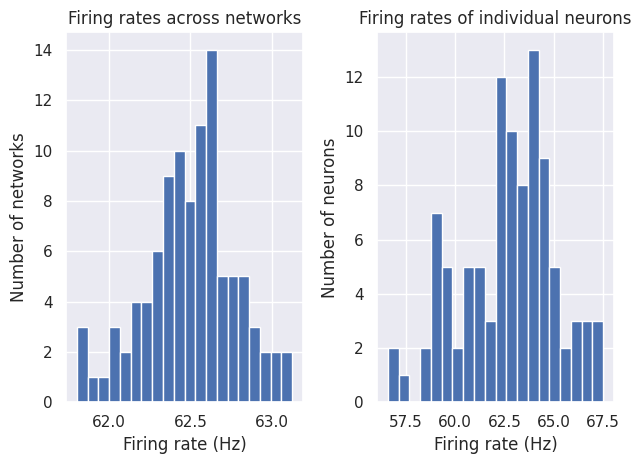

In [16]:
firing_rates = [X.float().mean().item() * 1000 for X in results.split(n_neurons, dim=0)] # Firing rates in Hz

fig, ax = plt.subplots(1, 2)

ax[0].hist(firing_rates, bins=20)
ax[0].set_title("Firing rates across networks")
ax[0].set_xlabel("Firing rate (Hz)")
ax[0].set_ylabel("Number of networks")

example_spikes = results.split(n_neurons, dim=0)[torch.randint(0, n_networks, (1,))]
network_firing_rates = example_spikes.float().mean(dim=1)*1000

ax[1].hist(network_firing_rates, bins=20)
ax[1].set_title("Firing rates of individual neurons")
ax[1].set_xlabel("Firing rate (Hz)")
ax[1].set_ylabel("Number of neurons")

plt.tight_layout()
plt.show()

Looks like the firing rates were centered around our target firing rate 62.5 Hz as expected.

Now the level of activity for each neuron might change over time, so let's make a raster plot to see how firing rates vary with time.
We will make two plots, one where we calculate the firing rate in 100 ms bins throughout the simulation and one where we take a closer look at the a particular section of the simulation.

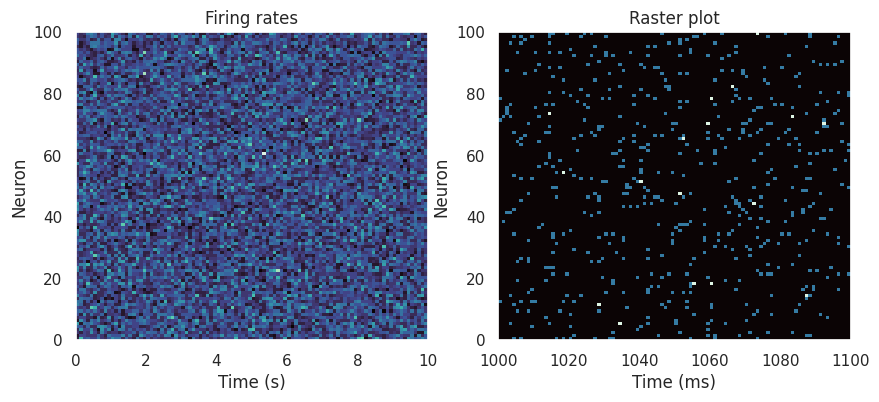

In [17]:
# Bin the firing rates
binned_firing_rates = example_spikes.float().view(n_neurons, -1, 100).mean(dim=2) * 1000

# Plot the time series and the spike distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].pcolormesh(binned_firing_rates, cmap="mako")
ax[0].set_title("Firing rates")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Neuron")
ax[0].set_xticks([20*i for i in range(6)])
ax[0].set_xticklabels([2*i for i in range(6)])

# Section of the time series
section = example_spikes[:, 1000:1100]
ax[1].pcolormesh(section, cmap="mako")
ax[1].set_title("Raster plot")
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Neuron")
ax[1].set_xticks([20*i for i in range(6)])
ax[1].set_xticklabels([1000 + 20*i for i in range(6)])
plt.show()

In the absence of any stimulus, there seems to be no clear temporal structure here. For examples of simulating with an added stimulus see `stimulate_with_stimulus.ipynb` and `working_with_stimulus.ipynb`.